Chapter 7 of Bayesian Methods For Hackers (Cameron Davidson)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
%matplotlib inline
import theano.tensor as T
import scipy.stats as stats

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Let's say our company would like customers to choose a higher-priced plan when presented when multiple plans. Suppose we'd like to determine the expected revenue we make per visitor to the website with those plan options.

# Expected revenue of one website
Supposed the website shows the visitor 4 different membership plans, where each plan has probability `p` of being picked, with its dollar value being 79, 49, 25 or 0 if none were chosen. All the probabilities sum up to 1: 
    * E[R] = p79, p49, p25, p0
We can't use the binomial distribution for this data because there are more than two categories. Also, we can't use Beta prior for the parameters of the distribution because the probabilities are correlated and they need to sum up to 1. For example, if p79 is high, then the other probabilities must be low. We need to model all the probabilities together.

Thus, we will use the multinomial distribution.

C:\Users\adam\Anaconda3\lib\site-packages\theano\tensor\basic.py:2184: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


With 100 trials and 4 different P's, the distribution will divide into 4 categories with p distributions.
For example, here it divided into 26+33+1+40=100, which are similar to our set p above.


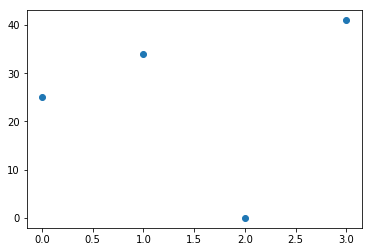

In [37]:
"""Example of multinomial"""
np.random.seed(seed=8)
plt.plot(pm.Multinomial.dist(n=100, p=[20,40,1,39]).random(4), 'o')
print("With 100 trials and 4 different P's, the distribution will divide into 4 categories with p distributions.")
print("For example, here it divided into 26+33+1+40=100, which are similar to our set p above.")

For our sign-up page, our observations follow a multinomial distribution. However, since we do not know the 'true' value of the probability vector p for p79, p49, p25, p0 dollars, we need to set a prior parameter for that value.

The Dirichlet distribution (which is a generalization of the Beta distribution when dirichlet ([1,1])) is a conjugate prior to the multinomial distribution. This means that we have the exact formulas for the posterior of the unknown probabilities. 

If our prior is Dirichlet(1,1,1,...1), and our observables are N1,N2,...Nm, then our posterior is:
* Direchlet (1+N1 + 1+N2, ..., 1+NM), which will always sum up to 1. 

In [3]:
from numpy.random import dirichlet

N = 1000    # 1000 visitors to webpage
N_79 = 10   # 10 bought the $79 membership
N_49 = 46   # 46 bought the $46 membership
N_25 = 80
N_0 =  N - (N_79 + N_49 + N_25 )

prior_parameters = np.array([1,1,1,1])
observations = np.array([N_79, N_49, N_25, N_0])
posterior_samples = dirichlet(prior_parameters + observations, size=10000)

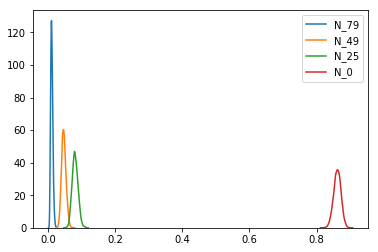

In [4]:
sns.kdeplot(posterior_samples[:, 0], label='N_79')
sns.kdeplot(posterior_samples[:, 1], label='N_49')
sns.kdeplot(posterior_samples[:, 2], label='N_25')
sns.kdeplot(posterior_samples[:, 3], label='N_0')
plt.show()

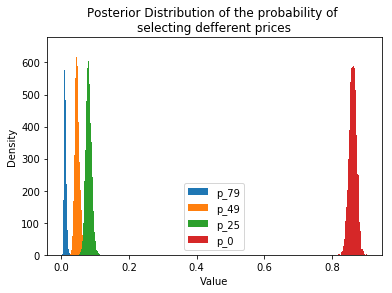

In [5]:
for i, label in enumerate(['p_79','p_49','p_25','p_0']):
    ax = plt.hist(posterior_samples[:,i], bins=50, label=label, histtype='stepfilled')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Posterior Distribution of the probability of \nselecting defferent prices')
plt.legend()
plt.show()

**The expected revenue per visitor, assuming 1000 visitors came to the webpage and saw the 4 membership plans**

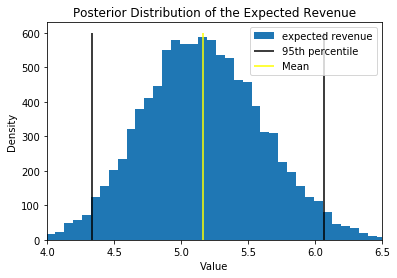

Expected revenue per visitor is between $5 - $5.5


In [6]:
def expected_revenue(p):
    return (79*p[:,0] + 49*p[:,1] + 25*p[:,2] + 0*p[:,3])

posterior_expected_revenue = expected_revenue(posterior_samples)
plt.hist(posterior_expected_revenue, histtype='stepfilled', label='expected revenue', bins=50)
plt.vlines(np.percentile(posterior_expected_revenue, q=[2.5,97.5]), 0,600, label='95th percentile')
plt.vlines(posterior_expected_revenue.mean(),0,600, label='Mean', color='yellow')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Posterior Distribution of the Expected Revenue')
plt.legend()
plt.xlim(4,6.5)
plt.show()          
print("Expected revenue per visitor is between $5 - $5.5")

In [7]:
print(posterior_samples[:,0].mean()*79)
print(posterior_samples[:,1].mean()*49)
print(posterior_samples[:,2].mean()*25)

0.8605448131498108
2.290489049397981
2.0144972395527976


# Running MCMC on multinomial likelihood

In [8]:
prior_parameters = np.array([1,1,1,1])

with pm.Model() as model1:
    theta = pm.Dirichlet('theta', np.array([1,1,1,1]), shape=4)
    
    membership_79_dollars = pm.Deterministic('membership_79_dollars', 79*theta[0])
    membership_49_dollars = pm.Deterministic('membership_49_dollars', 49*theta[1])
    membership_25_dollars = pm.Deterministic('membership_25_dollars', 25*theta[2])
    
    obs = pm.Multinomial("obs", n=observations.sum(), p=theta, observed=observations)
    trace = pm.sample(5000, tune=2000)

C:\Users\adam\Anaconda3\lib\site-packages\theano\tensor\basic.py:2184: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_stickbreaking__]


In [39]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta__0,0.010952,0.003273,0.000028,0.005050,0.017422,13879.789549,0.999946
theta__1,0.046789,0.006618,0.000054,0.034493,0.060190,15619.843305,0.999908
theta__2,0.080665,0.008541,0.000069,0.064065,0.097154,16907.023006,1.000034
theta__3,0.861594,0.010853,0.000093,0.839278,0.882034,15277.366279,1.000065
membership_79_dollars,0.865192,0.258542,0.002179,0.398930,1.376361,13879.789549,0.999946
membership_49_dollars,2.292681,0.324270,0.002668,1.690146,2.949307,15619.843305,0.999908
membership_25_dollars,2.016625,0.213513,0.001730,1.601618,2.428862,16907.023006,1.000034


In [68]:
print(posterior_samples[:, 0].mean())
print(posterior_samples[:, 1].mean())
print(posterior_samples[:, 2].mean())
print(posterior_samples[:, 3].mean())
print("\nWe see that running MCMC gives similar results of 'true' p to when we used the conjugate prior \
Dirichlet posterior formula without MCMC")

0.010892972318352035
0.04674467447750981
0.0805798895821119
0.8617824636220263

We see that running MCMC gives similar results of 'true' p to when we used the conjugate prior Dirichlet posterior formula without MCMC


**The expected revenue per visitor**

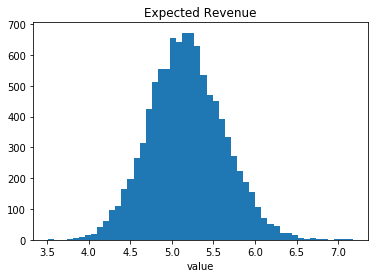

Expected revenue per visitor to webpage, using MCMC
5.174496957088042

Expected revenue per visitor to webpage, using conjugate prior Dirichlet posterior formula
5.165531102100588


In [66]:
revenue_per_visitor = trace['membership_79_dollars'] + trace['membership_49_dollars'] + trace['membership_25_dollars']
plt.hist(revenue_per_visitor, bins=50)
plt.title("Expected Revenue")
plt.xlabel('value')
plt.show()

print("Expected revenue per visitor to webpage, using MCMC")
print(revenue_per_visitor.mean())
print("\nExpected revenue per visitor to webpage, using conjugate prior Dirichlet posterior formula")
print(posterior_expected_revenue.mean())

# Comparing expected revenue between 2 webpages

In [295]:
from numpy.random import dirichlet

N_A = 1000    # 1000 visitors to webpage A
N_A_79 = 10   # 10 bought the $79 membership
N_A_49 = 46   # 46 bought the $46 membership
N_A_25 = 80
N_A_0 =  N_A - (N_A_79 + N_A_49 + N_A_25)
observations_A = np.array([N_A_79, N_A_49, N_A_25, N_A_0])

N_B = 2000     # 2000 visitors to webpage B
N_B_79 = 45   
N_B_49 = 84   
N_B_25 = 200
N_B_0 =  N_B - (N_B_79 + N_B_49 + N_B_25)
observations_B = np.array([N_B_79, N_B_49, N_B_25, N_B_0])

prior_parameters = np.array([1,1,1,1])
posterior_samples_A = dirichlet(prior_parameters + observations_A, size=10000)
posterior_samples_B = dirichlet(prior_parameters + observations_B, size=10000)

In [296]:
def expected_revenue(p):
    return (79*p[:,0] + 49*p[:,1] + 25*p[:,2] + 0*p[:,3])

posterior_expected_revenue_A = expected_revenue(posterior_samples_A)
posterior_expected_revenue_B = expected_revenue(posterior_samples_B)

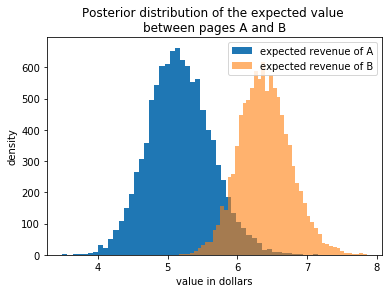

6.394672038907975

In [297]:
plt.hist(posterior_expected_revenue_A, bins=50, histtype='stepfilled', label='expected revenue of A')
plt.hist(posterior_expected_revenue_B, bins=50, histtype='stepfilled', label='expected revenue of B', alpha=0.6)
plt.xlabel('value in dollars')
plt.ylabel('density')
plt.title("Posterior distribution of the expected value \nbetween pages A and B")
plt.legend()
plt.show()
posterior_expected_revenue_B.mean()

In [298]:
print("There is a "+str((posterior_expected_revenue_B > posterior_expected_revenue_A).mean())+" chance that \
the expected revenue per visitor for page B is higher than that of page A.")


There is a 0.981 chance that the expected revenue per visitor for page B is higher than that of page A.


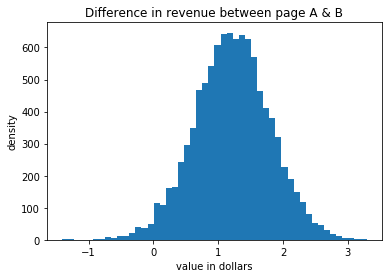

In [299]:
difference_in_revenue = (posterior_expected_revenue_B - posterior_expected_revenue_A)

plt.hist(difference_in_revenue, bins=50)
plt.title("Difference in revenue between page A & B")
plt.xlabel('value in dollars')
plt.ylabel('density')
plt.show()

# Increase in Dollars

In [300]:
print("The mean increase in revenue-per-visitor-to-webpage B vs. webpage A is:")
print(str(round(np.mean(difference_in_revenue),2))+ " Dollars")
print("\nThe likelihood of the increase between B and A being higher than $0 is:")
print((difference_in_revenue>0).mean())
print("\nThe likelihood of the increase between B and A being higher than $2 is:")
print((difference_in_revenue>2).mean())


The mean increase in revenue-per-visitor-to-webpage B vs. webpage A is:
1.22 Dollars

The likelihood of the increase between B and A being higher than $0 is:
0.981

The likelihood of the increase between B and A being higher than $2 is:
0.0877


# Relative Increase

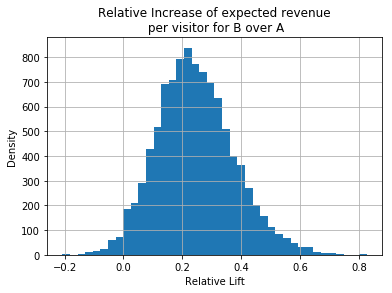

In [301]:
def relative_increase(a,b):
    return ((b-a)/a)          #b comes first in this case because revenue B > A

posterior_rel_increase = relative_increase(posterior_expected_revenue_A, posterior_expected_revenue_B)
plt.hist(posterior_rel_increase, bins=40)
plt.ylabel('Density')
plt.xlabel('Relative Lift')
plt.grid()
plt.title("Relative Increase of expected revenue\n per visitor for B over A")
plt.show()

Let's numerically visualize what the formula above is doing.

In [302]:
print(posterior_expected_revenue_B.mean())
print(posterior_expected_revenue_A.mean())
print("\nThus, we see an average percentage increase in revenue:")
print((posterior_expected_revenue_B.mean() - posterior_expected_revenue_A.mean()) / posterior_expected_revenue_A.mean())

6.394672038907975
5.175073574740435

Thus, we see an average percentage increase in revenue:
0.23566785023509768


In [282]:
print("Likelihood that the expected revenue per visitor for webpage B is larger than A's by 50% or more is:")
print((posterior_rel_increase > 0.5).mean())
print("\nLikelihood that the expected revenue per visitor for webpage B is larger than A's by 33% or more is:")
print((posterior_rel_increase > 0.33).mean())

Likelihood that the expected revenue per visitor for webpage B is larger than A's by 50% or more is:
0.0354

Likelihood that the expected revenue per visitor for webpage B is larger than A's by 33% or more is:
0.2455
